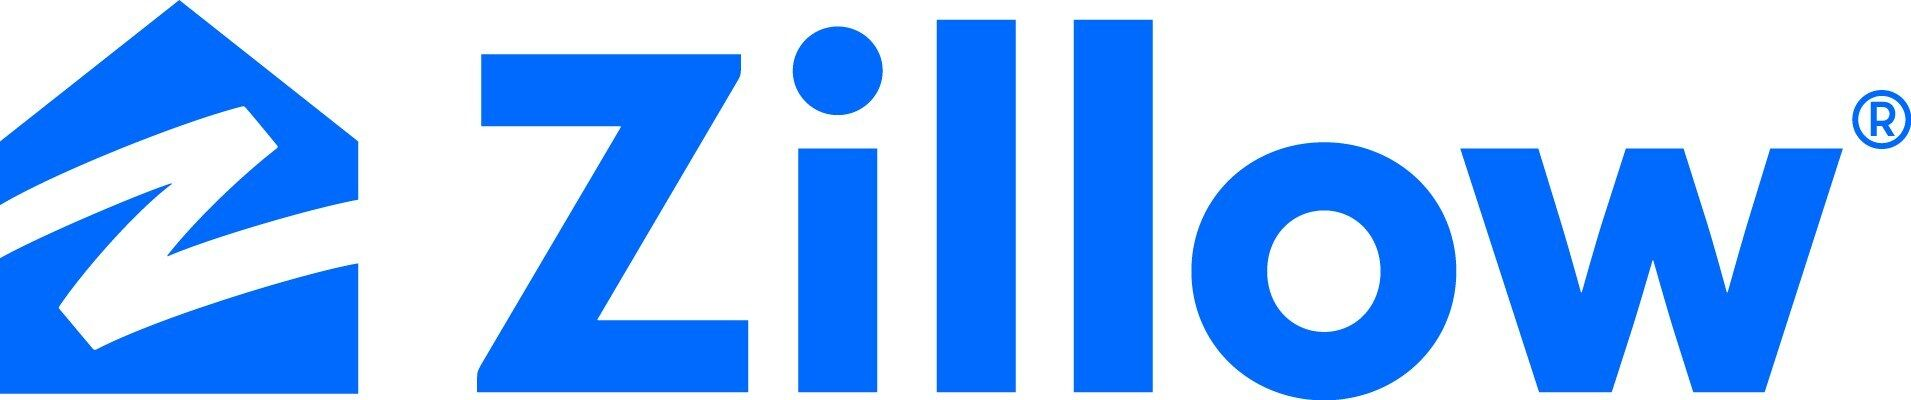

# Regression Project - Zillow_2017

Caroline Miller

April 10, 2023

O'Neil Data Science Cohort

**Goal:** Identify key drivers of home value for Single Family properties within Orange, Colusa, and Los Angeles Counties, and to create a model which can predict the home value better than the baseline predictions. Home values represent a great and costly investment for home owners, banks, and real eastate companies. The flucuation in the real esatte market directly affects our business and our customers. It is important to track trends and drivers of home values in order to maintain a continous understanding of a market which has proven to be volatile. 

**Project Description:** This project analyzes historical data from our company to find correlation between variables which we track and the tax value. The data specifically looks at homes in three California counties which sold in 2017. The variables assessed include the age of the property, the sqaurefeet, the number of bedrooms and bathrooms, and the county in which the property is located. Through this data analysis, I identify key drivers. I then use those key drivers make a predictive model.

#### Imports

In [1]:
import pandas as pd
import numpy as np
import wrangle
import matplotlib.pyplot as plt

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pydataset import data

import seaborn as sns
import evaluate
import scipy.stats as stats

#### Data Dictionary

| Object Returned | Description | Purpose                          |
|:-------------------|:--------------------------------|:----------------------------------------------------|
| 1. bedrooms | **Feature** and dependent variable, number of bedrooms within the property | float64 datatype |
| 2. bathrooms | **Feature** and dependent variable, number of bathrooms within the property | float64 datatype    |
| 3. squarefeet | **Feature** and dependent variable, area of the property | float64 datatype |
| 4. tax_value | **Target** and independent variable, **Unscaled**, measured in USD | Feature selection, evaluate model predictions, float64 datatype |
| 5. yearbuilt | **Feature** and dependent variable, year the property was constructed | int64 datatype |
| 6. taxamount | **Feature** and dependent variable, percentage of tax_value, relative to tax_va;ue, measured in USD | float64 datatype |
| 7. fips | **Feature** and dependent variable, number representing a State and county in which the property is located  | int64 datatype |
| 8. propertytypeid | **Feature** and dependent variable, number representing the type of construction accoring to Zillow standard procedures   | int64 datatype |
| 9. transactiondate | **Feature** and dependent variable, year in which the property was purchased by a customer (within 2017)   | datetime64 datatype |
| 10. fips_location | **Feature** and dependent variable, State and county in which the property is located  | object datatype |
| 11. property_age | **Feature** and dependent variable, difference between year the property was constructed and year in which the transaction was made (2017) | int64 datatype |

### Acquire

In [2]:
# Use function from wrangle.py to acquire the unclean/unprepared dataframe

zillow = wrangle.get_zillow_2017()
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    52442 non-null  int64  
 1   parcelid                      52442 non-null  int64  
 2   bedroomcnt                    52442 non-null  float64
 3   bathroomcnt                   52442 non-null  float64
 4   calculatedfinishedsquarefeet  52360 non-null  float64
 5   taxvaluedollarcnt             52441 non-null  float64
 6   yearbuilt                     52326 non-null  float64
 7   taxamount                     52438 non-null  float64
 8   fips                          52442 non-null  float64
 9   propertylandusetypeid         52442 non-null  float64
 10  transactiondate               52442 non-null  object 
dtypes: float64(8), int64(2), object(1)
memory usage: 4.4+ MB


This dataframe is acquired using a function which imports the dataframe from MySQL.

It joins three tables which results in 52,442 rows and 11 columns.

Each row represents a single family property, and each column represents a feature pretaining to that specific property.

#### Prepare

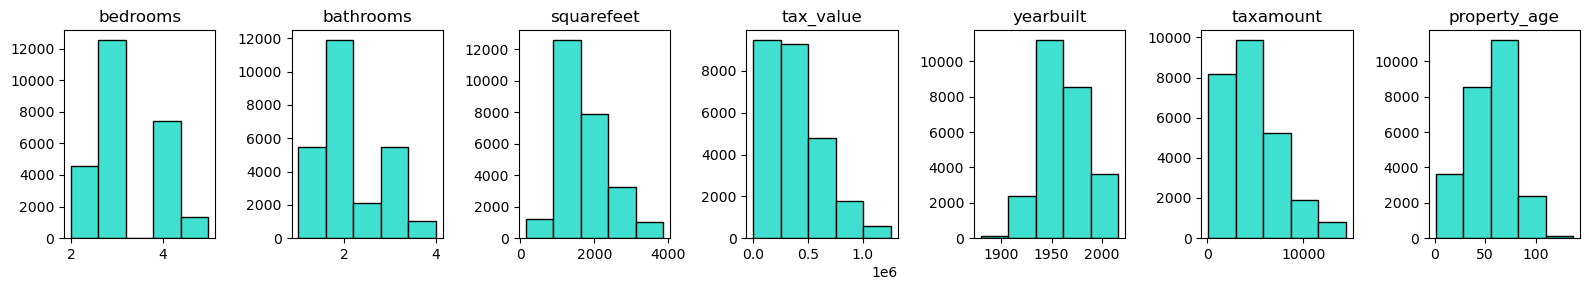

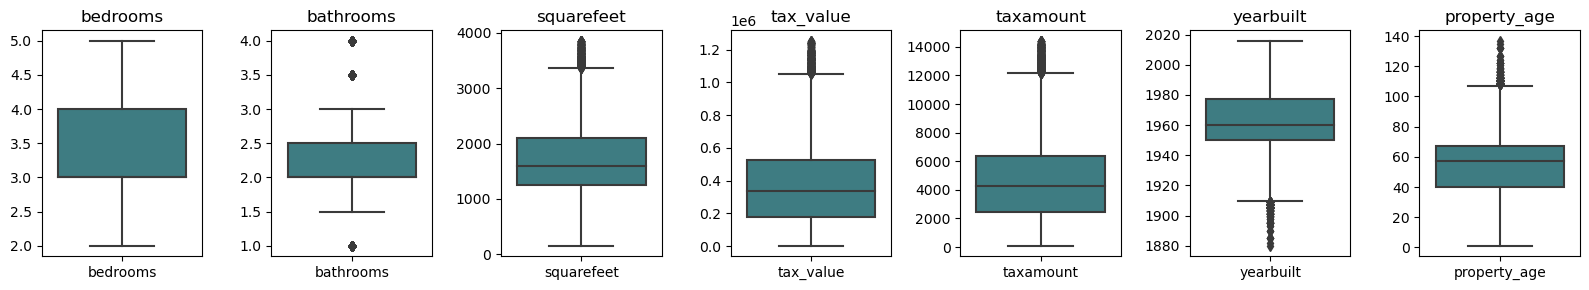

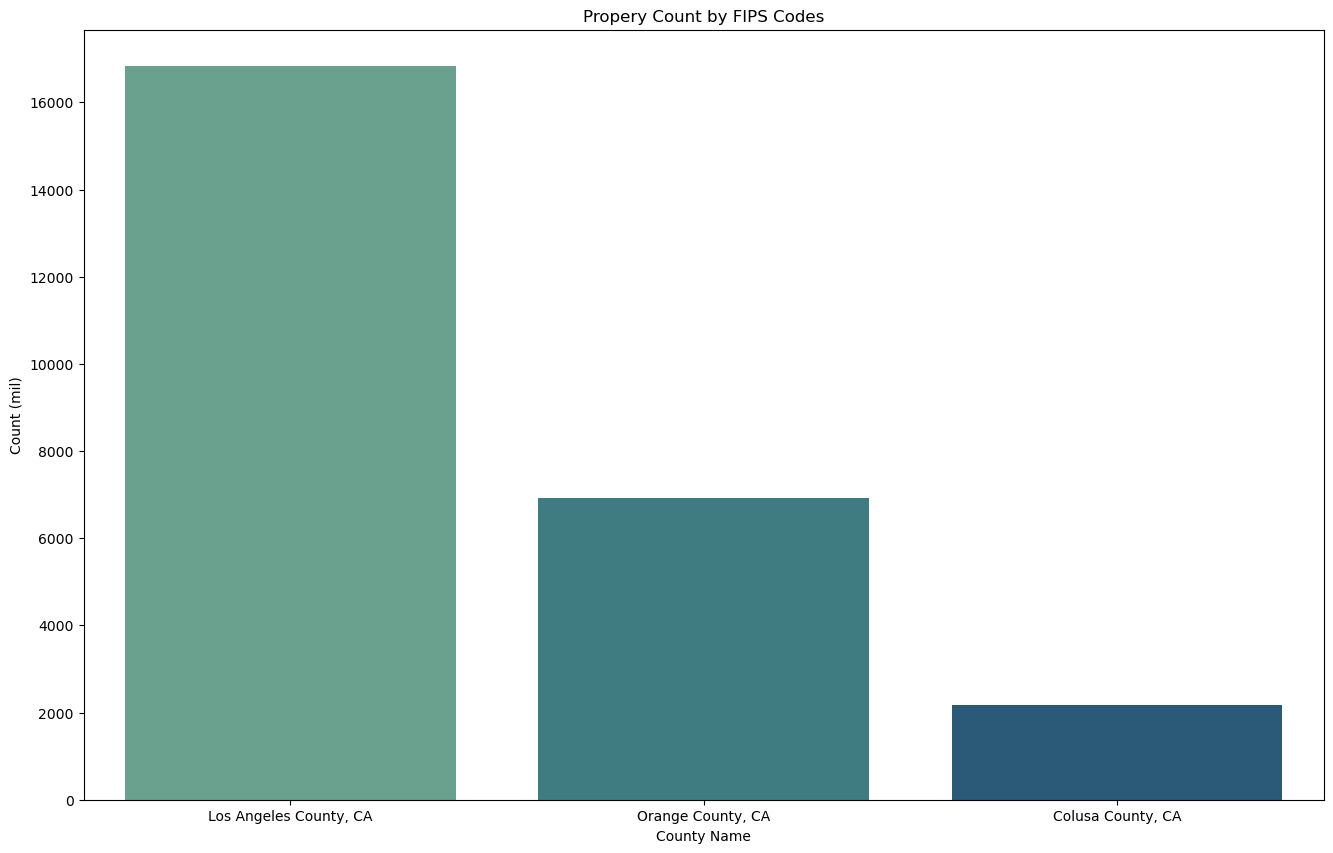

In [3]:
# Use function from wrangle.py to clean and split the dataframe into three datasets. this function also 
# visualizes the different features and target based on the datatype of the Series

train, validate, test = wrangle.prepare_zillow(zillow)

The prepare function conducts the following on the dataframe:

    1. Drops the 'parcelid' column
    2. Converts the transaction date from an object datatype to a datetime datatype
    3. Renames a few columns
    4. Removes the outliers from all the int and float type features
    5. Adds a column containing the county and state to which the fips in pertaining 
    6. Splits the dataframe into a train, validate, and test dataframe 
    7. Uses the median strategy for the SimpleImputer to fill the NaN values with the median year in which the property was built
    8. Adds a column containing the age of the property by subtracting the year built by 2017
    9. Using the train dataframe, the function visualizes the continuous variables using histograms and boxplots, and the function visualizes the discrete varibales using a countplot
    10. Returns the train, validate, and test datasets

### Explore

Questions from the Zillow team:

    1. Find the key drivers of property value for single family properties. 
    2. Why do some properties have a much higher value than others when they are located so close to each other? 
    3. Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? 
    4.Is having 1 bathroom worse than having 2 bedrooms?

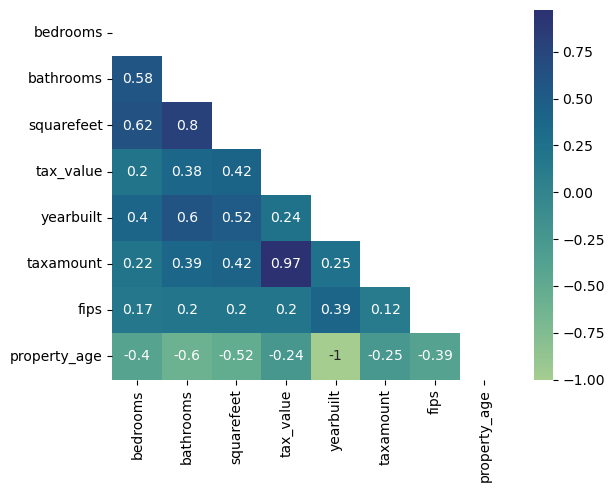

In [4]:
# Call function from wrangle.py which visualizes the features through univariate, bivariate, and 
# multivariate exploratory analysis

# wrangle.viz_explore(train, 'tax_value')

zillow_corr = train.drop(columns={'transactiondate', 'propertytypeid'}).corr(method='spearman')
sns.heatmap(zillow_corr, cmap='crest', annot=True, mask=np.triu(zillow_corr))
plt.show()

**Key Findings:**

Univariate Assessment:

    - Most properties have 3 bedrooms
    - Most properties are in Los Angeles County
    - Most properties have 2 bathrooms
    - The distribution of squarefeet is skewd to the right, with the most properties having around 1500 squarefeet
    - The distribution of tax value (target) is skewed to the right with the majority of properties being between $200,000 and $500,000
    - The distribution of year built is normal, with most properries built between 1950 and 1970
    - The distribution of tax amount mirrors that of tax value
    - The dustributuin of property age is normal with most properties being around 60 years old

Bivariate Assessment:

    - The tax value increases as the amount of bedrooms increases (possible correlation)
    - The tax value increases as the amount of bathrooms increases (possible correlation)
    - The tax value is highest in Orange County then Colusa then Los Angles
    - Squarefeet seems to increase as the tax value increases(possible correlation)
    - Tax value and tax amount increase together, as can be expected
    - No significant relationship can be observed between tax value and property age nor year built
    
Heatmap Assessment:

    - There is a negative correlation between property age
    - The greatest correlations between tax value and other features are bathrooms and sqaurefeet other than that of tax amount

#### Question 1:  Find the key drivers of property value for single family properties. 

We will test the relationships between tax value and bathrooms and tax value and squarefeet.

H$_O$:  There is no linear relationship between tax value and the number of bathrooms in a property.

H$_A$:  There is a linear relationship between tax value and the number of bathrooms in a property.

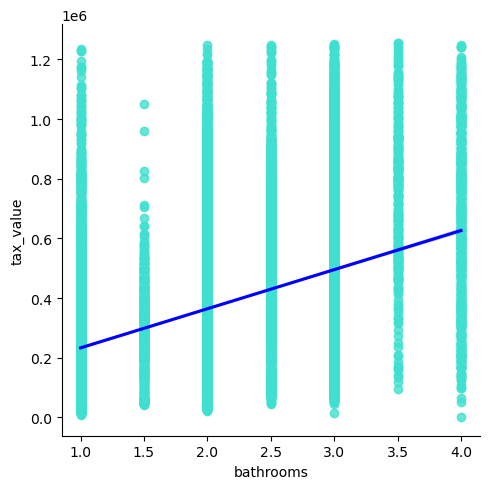

In [5]:
# Plots the saturation and range of each bathroom value in the train dataframe.
# You can see that as the number of bathrooms increases, so does tax value

sns.lmplot(data=train, 
          x='bathrooms', 
          y='tax_value', scatter_kws={'color': 'turquoise'},
          line_kws={'color': 'blue'})

A correlation statistical test is conducted to determine if number of bathrooms has a linear relationship to the target variable of tax value.

In [6]:
r, p = stats.pearsonr(train.bathrooms, train.taxamount)
α = 0.05

if p < α:
    print(f'We must reject the null hypothesis that there is no linear relationship between the number of bathrooms and the tax amount with a p value of {p}.')

else:
    print('We fail to reject the null hypothesis.')
print(r)

We must reject the null hypothesis that there is no linear relationship between the number of bathrooms and the tax amount with a p value of 0.0.
0.392681121745632


H$_O$:  There is no linear relationship between tax value and the squarefeet of a property.

H$_A$:  There is a linear relationship between tax value and the squarefeet of a property.

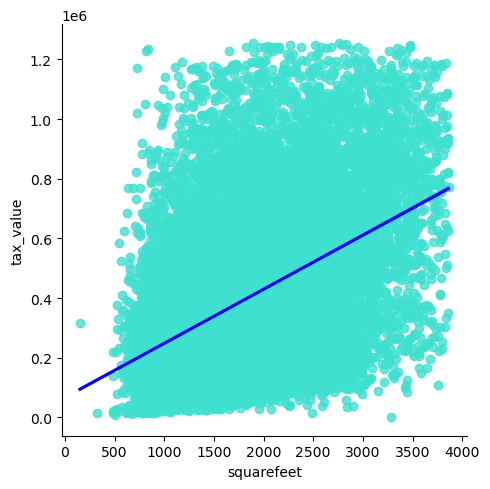

In [7]:
# Plots the saturation and range of squarefeet in the train dataframe.
# You can see that as the squarefeet increases, so does tax value

sns.lmplot(data=train, 
          x='squarefeet', 
          y='tax_value', scatter_kws={'color': 'turquoise'},
          line_kws={'color': 'blue'})

A correlation statistical test is conducted to determine if the area (squarefeet) has a linear relationship to the target variable of tax value.

In [8]:
r, p = stats.pearsonr(train.squarefeet, train.taxamount)
α = 0.05

if p < α:
    print(f'We must reject the null hypothesis that there is no linear relationship between the squarefeet and the tax amount with a p value of {p}.')

else:
    print('We fail to reject the null hypothesis.')

We must reject the null hypothesis that there is no linear relationship between the squarefeet and the tax amount with a p value of 0.0.


**Answer:**  To support the findings of the bivariate and multivaraite visulizations and exploration, we can conclude as a product of the statistical testing that the features squarefeet and number of bathrooms are both key drivers of property value.

#### Question 2:  Why do some properties have a much higher value than others when they are located so close to each other? 

In [9]:
# The train dataframe is split into three subsets, each containing the data from the three different
# counties

la_county = train[train['fips_location'] == 'Los Angeles County, CA']
colusa_county = train[train['fips_location'] == 'Colusa County, CA']
orange_county = train[train['fips_location'] == 'Orange County, CA']

Using the describe() function, we can observe the statistics of each dataframe. We can see that on average (looking at the mean of the target) the home values in Orange County are the highest, with Colusa County not far behind, and LA county a bit less valuable

We can also see that on average the properties in Colusa County are larger

We can see that on average, across the three counties, there are 3 bedrooms, 2 bathrooms in each property

Properties in Los Angeles County tend to be a bit older

In [10]:
la_county.describe()

,bedrooms,bathrooms,squarefeet,tax_value,yearbuilt,taxamount,fips,propertytypeid,property_age
count,16825.000000,16825.000000,16825.000000,1.682500e+04,16825.000000,16825.000000,16825.0,16825.0,16825.000000
mean,3.122556,2.024666,1640.040416,3.449744e+05,1956.860565,4481.424939,6037.0,261.0,60.139435
std,0.789226,0.778972,618.537694,2.458803e+05,22.094135,2895.693491,0.0,0.0,22.094135
min,2.000000,1.000000,152.000000,1.000000e+03,1882.000000,120.840000,6037.0,261.0,1.000000
25%,3.000000,1.000000,1188.000000,1.518900e+05,1947.000000,2255.440000,6037.0,261.0,50.000000
50%,3.000000,2.000000,1504.000000,2.943620e+05,1954.000000,3952.730000,6037.0,261.0,63.000000
75%,4.000000,3.000000,1963.000000,4.750000e+05,1967.000000,6014.480000,6037.0,261.0,70.000000
max,5.000000,4.000000,3858.000000,1.253000e+06,2016.000000,14437.490000,6037.0,261.0,135.000000


In [11]:
orange_county.describe()

,bedrooms,bathrooms,squarefeet,tax_value,yearbuilt,taxamount,fips,propertytypeid,property_age
count,6911.000000,6911.000000,6911.000000,6.911000e+03,6911.000000,6911.000000,6911.0,6911.0,6911.000000
mean,3.360585,2.299450,1881.960787,4.480273e+05,1971.881638,5186.463149,6059.0,261.0,45.118362
std,0.773421,0.620797,639.529277,2.614921e+05,16.920736,2931.483174,0.0,0.0,16.920736
min,2.000000,1.000000,480.000000,1.352400e+04,1893.000000,85.940000,6059.0,261.0,2.000000
25%,3.000000,2.000000,1379.000000,2.481280e+05,1960.000000,2925.390000,6059.0,261.0,33.000000
50%,3.000000,2.000000,1762.000000,4.274920e+05,1971.000000,4888.900000,6059.0,261.0,46.000000
75%,4.000000,2.500000,2301.000000,6.213755e+05,1984.000000,7015.240000,6059.0,261.0,57.000000
max,5.000000,4.000000,3858.000000,1.255422e+06,2015.000000,14397.900000,6059.0,261.0,124.000000


In [12]:
colusa_county.describe()

,bedrooms,bathrooms,squarefeet,tax_value,yearbuilt,taxamount,fips,propertytypeid,property_age
count,2172.000000,2172.000000,2172.000000,2.172000e+03,2172.000000,2172.000000,2172.0,2172.0,2172.000000
mean,3.471915,2.301796,1905.341160,4.329598e+05,1974.703499,5025.413186,6111.0,261.0,42.296501
std,0.740761,0.626610,657.646571,2.314084e+05,18.215950,2694.714525,0.0,0.0,18.215950
min,2.000000,1.000000,480.000000,9.242000e+03,1880.000000,138.540000,6111.0,261.0,2.000000
25%,3.000000,2.000000,1385.000000,2.717708e+05,1962.000000,3128.630000,6111.0,261.0,30.000000
50%,3.000000,2.000000,1800.000000,4.243190e+05,1973.000000,4834.760000,6111.0,261.0,44.000000
75%,4.000000,2.500000,2324.500000,5.644628e+05,1987.000000,6543.380000,6111.0,261.0,55.000000
max,5.000000,4.000000,3862.000000,1.237000e+06,2015.000000,14101.220000,6111.0,261.0,137.000000


Text(0.5, 1.0, 'Colusa County Tax Values')

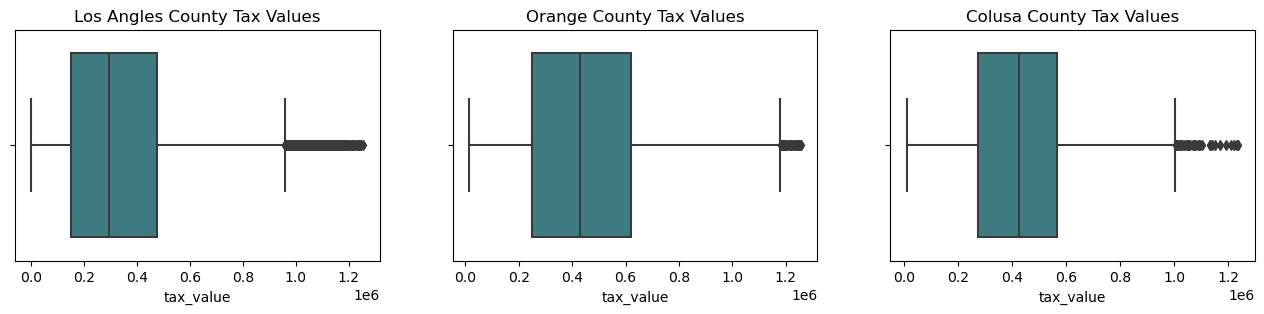

In [13]:
plt.figure(figsize=(16, 3))

plt.subplot(131)
sns.boxplot(la_county['tax_value'], palette='crest')
plt.title('Los Angles County Tax Values')

plt.subplot(132)
sns.boxplot(orange_county['tax_value'], palette='crest')
plt.title('Orange County Tax Values')

plt.subplot(133)
sns.boxplot(colusa_county['tax_value'], palette='crest')
plt.title('Colusa County Tax Values')

Takeways: 
    
    It seems that the same trend can be observed when looking at each county individually, though a linear relationship not observed before between tax value and property age may exist and may explain, in addition to number of bathrooms and sqaurefeet, why some properties' tax values vary so much within the same county.

Property Age Correlation Testing

In [14]:
r, p = stats.pearsonr(la_county.property_age, la_county.taxamount)
α = 0.05
print(r)
if p < α:
    print(f'We must reject the null hypothesis that there is no linear relationship between the age of a property and the tax amount with a p value of {p}.')

else:
    print('We fail to reject the null hypothesis.')

-0.13486960659216116
We must reject the null hypothesis that there is no linear relationship between the age of a property and the tax amount with a p value of 3.956355300612736e-69.


In [15]:
r, p = stats.pearsonr(orange_county.property_age, orange_county.taxamount)
α = 0.05
print(r)
if p < α:
    print(f'We must reject the null hypothesis that there is no linear relationship between the age of a property and the tax amount with a p value of {p}.')

else:
    print('We fail to reject the null hypothesis.')

-0.4563280699373506
We must reject the null hypothesis that there is no linear relationship between the age of a property and the tax amount with a p value of 0.0.


In [16]:
r, p = stats.pearsonr(colusa_county.property_age, colusa_county.taxamount)
α = 0.05
print(r)
if p < α:
    print(f'We must reject the null hypothesis that there is no linear relationship between the age of a property and the tax amount with a p value of {p}.')

else:
    print('We fail to reject the null hypothesis.')

-0.48472158733382487
We must reject the null hypothesis that there is no linear relationship between the age of a property and the tax amount with a p value of 2.2278352551249005e-128.


Number of Bedrooms Correlation Testing

In [17]:
r, p = stats.pearsonr(la_county.bedrooms, la_county.taxamount)
α = 0.05
print(r)
if p < α:
    print(f'We must reject the null hypothesis with a p value of {p}.')

else:
    print('We fail to reject the null hypothesis.')

0.20440179386638394
We must reject the null hypothesis with a p value of 3.7354575731049265e-158.


In [18]:
r, p = stats.pearsonr(orange_county.bedrooms, orange_county.taxamount)
α = 0.05
print(r)
if p < α:
    print(f'We must reject the null hypothesis with a p value of {p}.')

else:
    print('We fail to reject the null hypothesis.')

0.1917351681562685
We must reject the null hypothesis with a p value of 3.199237621933627e-58.


In [19]:
r, p = stats.pearsonr(colusa_county.bedrooms, colusa_county.taxamount)
α = 0.05
print(r)
if p < α:
    print(f'We must reject the null hypothesis with a p value of {p}.')

else:
    print('We fail to reject the null hypothesis.')

0.24820079230534056
We must reject the null hypothesis with a p value of 7.499241874177037e-32.


Number of Bathrooms Correlation Testing

In [20]:
r, p = stats.pearsonr(la_county.bathrooms, la_county.taxamount)
α = 0.05
print(r)
if p < α:
    print(f'We must reject the null hypothesis with a p value of {p}.')

else:
    print('We fail to reject the null hypothesis.')

0.35823858029001193
We must reject the null hypothesis with a p value of 0.0.


In [21]:
r, p = stats.pearsonr(orange_county.bathrooms, orange_county.taxamount)
α = 0.05
print(r)
if p < α:
    print(f'We must reject the null hypothesis with a p value of {p}.')

else:
    print('We fail to reject the null hypothesis.')

0.430028039698031
We must reject the null hypothesis with a p value of 3.82021030426967e-309.


In [22]:
r, p = stats.pearsonr(colusa_county.bathrooms, colusa_county.taxamount)
α = 0.05
print(r)
if p < α:
    print(f'We must reject the null hypothesis with a p value of {p}.')

else:
    print('We fail to reject the null hypothesis.')

0.48707695524191774
We must reject the null hypothesis with a p value of 8.587325741379032e-130.


Squarefeet Correlation Testing

In [23]:
r, p = stats.pearsonr(la_county.squarefeet, la_county.taxamount)
α = 0.05
print(r)
if p < α:
    print(f'We must reject the null hypothesis with a p value of {p}.')

else:
    print('We fail to reject the null hypothesis.')

0.42199260026342783
We must reject the null hypothesis with a p value of 0.0.


In [24]:
r, p = stats.pearsonr(orange_county.squarefeet, orange_county.taxamount)
α = 0.05
print(r)
if p < α:
    print(f'We must reject the null hypothesis with a p value of {p}.')

else:
    print('We fail to reject the null hypothesis.')

0.4879857734747151
We must reject the null hypothesis with a p value of 0.0.


In [25]:
r, p = stats.pearsonr(colusa_county.squarefeet, colusa_county.taxamount)
α = 0.05
print(r)
if p < α:
    print(f'We must reject the null hypothesis with a p value of {p}.')

else:
    print('We fail to reject the null hypothesis.')

0.5850982809129286
We must reject the null hypothesis with a p value of 9.94486255460209e-200.


**Answer:**  It appears that the number of bathrooms and bedrooms, as well the squarefeet and the property age all correlate with the tax value of a property, and therefore I can conclude the following with some confidence. Even within the same county, the tax value of a property will increase the more bedrooms, bathrooms, and squarefeet it has, but the tax value will decrease the older the property is. 

#### Question 3:  Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? 

Text(0.5, 1.0, 'Bathrooms by County')

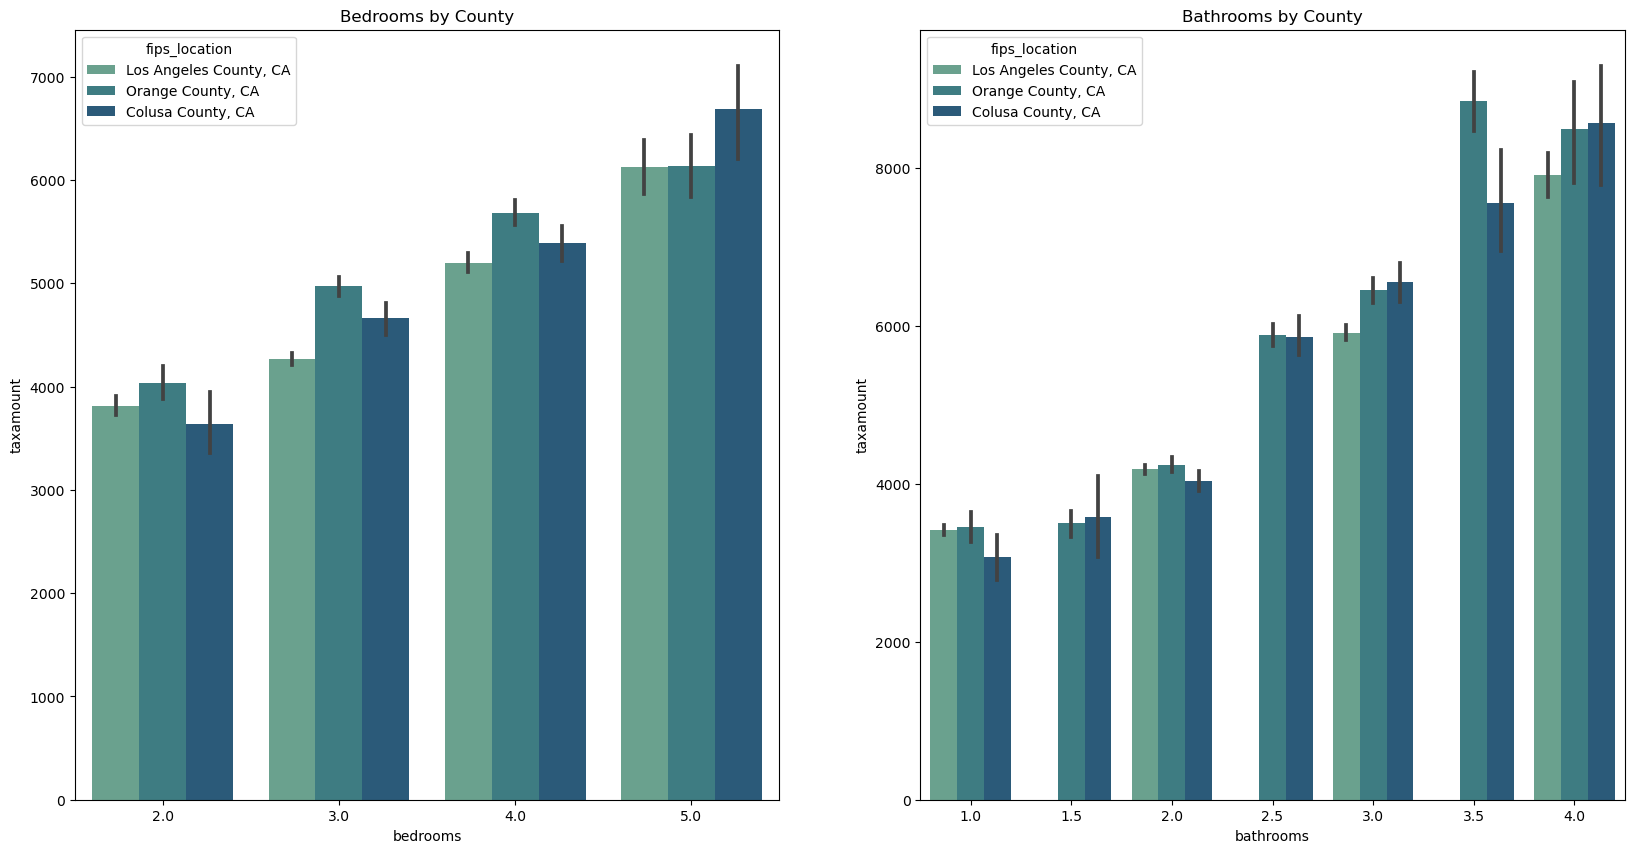

In [26]:
# Plotting the realtionship between bathrooms/bedrooms and tax value by county

plt.figure(figsize=(20, 10))

plt.subplot(121)
sns.barplot(data=train, x='bedrooms', y='taxamount', hue='fips_location', palette='crest')
plt.title('Bedrooms by County')

plt.subplot(122)
sns.barplot(data=train, x='bathrooms', y='taxamount', hue='fips_location', palette='crest')
plt.title('Bathrooms by County')

Text(0.5, 1.0, 'Property Age by County')

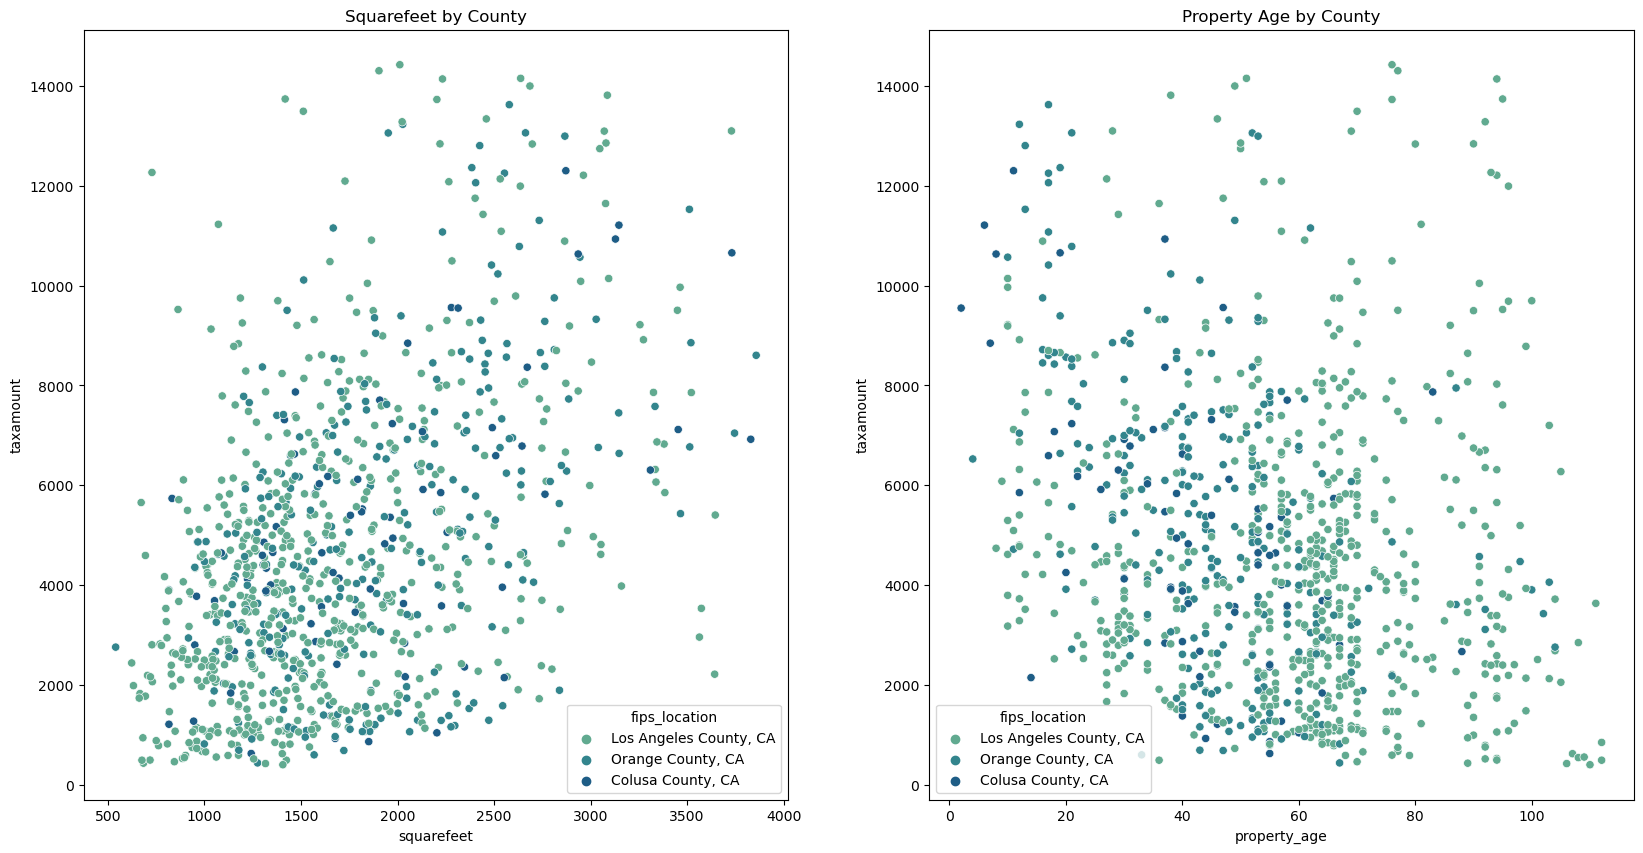

In [27]:
# plotting a sample of each county's train data to see if any distinguishable clusters appear

plt.figure(figsize=(20, 10))

train_sample = train.sample(n=1000)

plt.subplot(121)
sns.scatterplot(data=train_sample, x='squarefeet', y='taxamount', hue='fips_location', palette='crest')
plt.title('Squarefeet by County')

plt.subplot(122)
sns.scatterplot(data=train_sample, x='property_age', y='taxamount', hue='fips_location', palette='crest')
plt.title('Property Age by County')

**Answer:**  It appears that perhaps properties in Los Angeles county are a bit older, and therefore the property age may be a reason why properties are less valuable. According to the graph, it is not obvious that there is a visible difference between home values in each county as the numbr of bathrooms/bedrooms increases nor is it obvious that any of the properties in any of the three counties is distinguishable in home value as the squarefeet increases.

#### Question 4:  Is having 1 bathroom worse than having 2 bedrooms?

H$_O$:  There is no difference in the means of the tax values of properties that have 1 bathroom and properties that have 2 bathrooms. 

H$_A$: The means of the tax values of properties with 2 bathrooms is greater than that of properties with 1 bathroom. 

Text(0.5, 1.0, 'Properties with 2 Bathrooms')

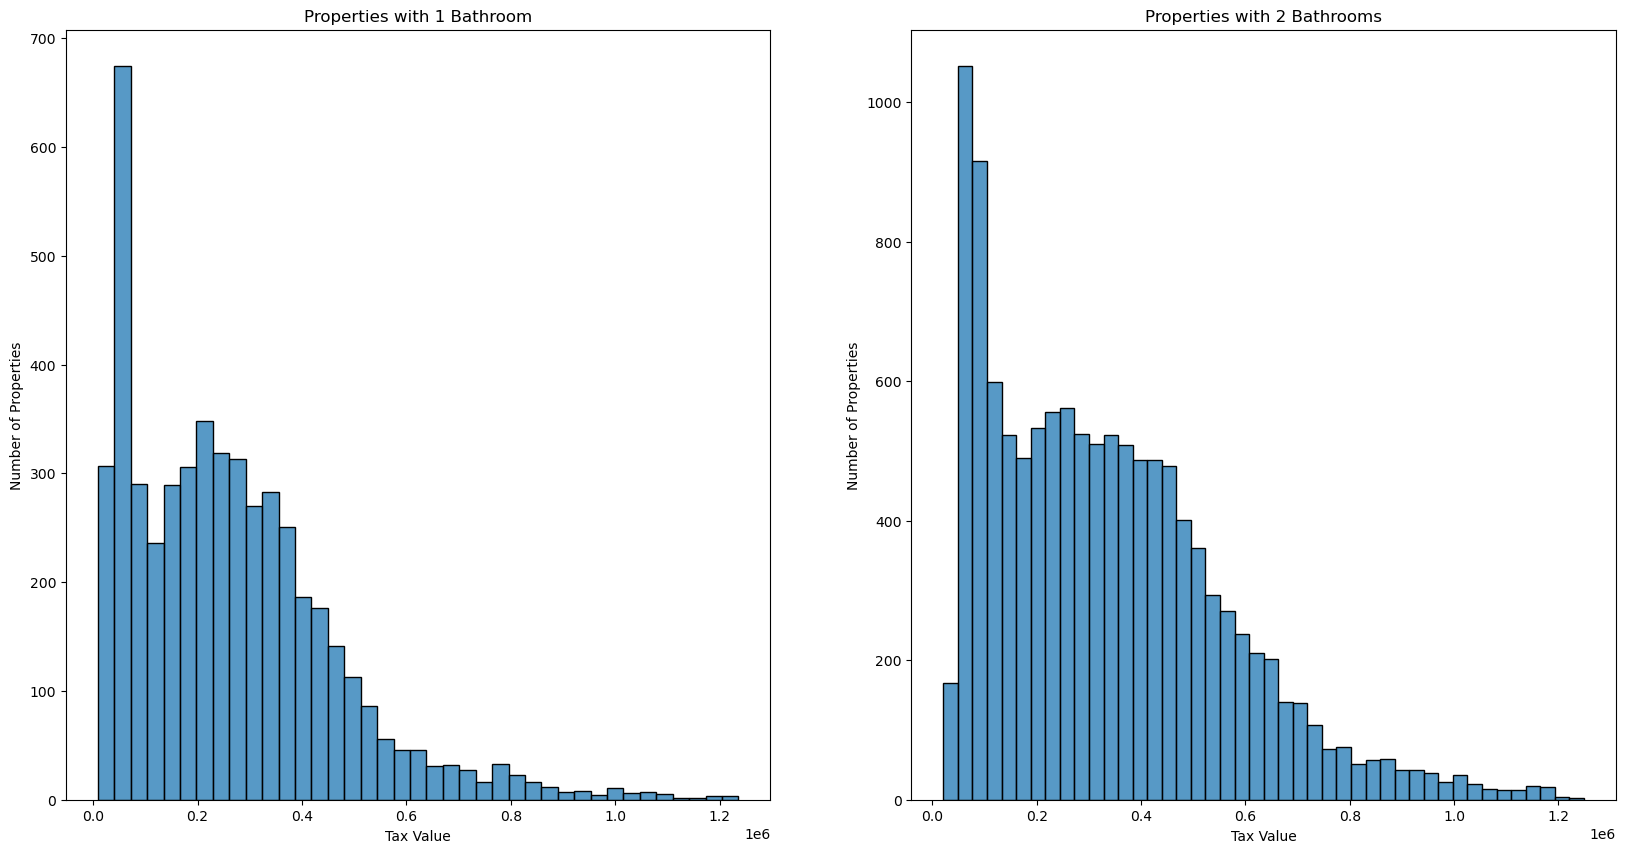

In [28]:
# plotting the distributions of the properties with one bathroom and the properties with two bathrooms

plt.figure(figsize=(20, 10))

plt.subplot(121)
sns.histplot(train.tax_value[train.bathrooms == 1], palette='crest')
plt.xlabel('Tax Value')
plt.ylabel('Number of Properties')
plt.title('Properties with 1 Bathroom')

plt.subplot(122)
sns.histplot(train.tax_value[train.bathrooms == 2], palette='crest')
plt.xlabel('Tax Value')
plt.ylabel('Number of Properties')
plt.title('Properties with 2 Bathrooms')


H$_O$:  The means of tax values between properties with 1 bathroom and properties with 2 bathrooms have equal variance. 

H$_A$:  The means of tax values between properties with 1 bathroom and properties with 2 bathrooms do NOT have equal variance. 

In [29]:
# Conducting a levene stats test to determine if there is equal variance in the means of 
# the two independent samples

In [30]:
two_bath = train[train.bathrooms == 2].tax_value
one_bath = train[train.bathrooms == 1].tax_value

stat, p = stats.levene(two_bath, one_bath)
α = 0.05

if p < α:
    print(f'p value: {p}; We must reject the null hypothesis and assume unequal variance.')
else:
    print(f'p value: {p};We cannot reject the null hypothesis, and we can assume equal variance.')

p value: 5.612826475385169e-34; We must reject the null hypothesis and assume unequal variance.


In [31]:
# Seeing that the variance is inequal, I outline this within the parameters of the T-test
# to compare the tax values of these two independent samples

In [32]:
t_stat, p_val = stats.ttest_ind(two_bath, one_bath, equal_var=False)

if p < α and (t_stat / 2) > 0:
    print('We must reject the null hypothesis.')

We must reject the null hypothesis.


**Answer:**  The mean of the tax value of properties with 2 bathrooms is greater than that of properties with 1 bathroom, and therefore it is worse to have only 1 bathroom compared to having 2. 

#### Exploration Summary:

    - Through statistical testing, I can conclude with confidence that the following features correlate with a home's value:
    
        1. squarefeet
        2. number of bathrooms
        3. number of bedrooms
        4. property age
        
    - I can also conclude that homes with the same physical features are valued differnently based on in which county they are located
    
    - A property's age has a negative linear realtionship with home value

### Modeling

In [33]:
# Using the function fro wrangle.py, we scale the designated features of the train, validate, and 
# test sets

train_scaled, validate_scaled, test_scaled = wrangle.scale_data(train, validate, test, columns_to_scale=['squarefeet', 'bedrooms', 'bathrooms', 'property_age', 'yearbuilt'])

In [34]:
# Splitting the scaled sets to isolate the target variable from the chosen modeling features

model_feats = ['squarefeet', 'bedrooms', 'bathrooms']
X_train = train_scaled[model_feats]
y_train = train_scaled[['tax_value']]

X_val = validate_scaled[model_feats]
y_val = validate_scaled[['tax_value']]

X_test = test_scaled[model_feats]
y_test = test_scaled[['tax_value']]

#### Baseline

In [35]:
# To create the baseline model, we will calculate the mean and median of the target variable Series
# and then calculate the RMSE of the train and validate datasets to see which has the least area of error

tax_value_pred_median = y_train.tax_value.median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_val['tax_value_pred_median'] = tax_value_pred_median

tax_value_pred_mean = y_train.tax_value.mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_val['tax_value_pred_mean'] = tax_value_pred_mean

rmse_train_mu = mean_squared_error(y_train.tax_value,
                                y_train.tax_value_pred_mean) ** .5

rmse_validate_mu = mean_squared_error(y_val.tax_value, y_val.tax_value_pred_mean) ** (0.5)

print(f"""RMSE using Mean\nTrain/In-Sample: {round(rmse_train_mu, 2)} 
      Validate/Out-of-Sample: {round(rmse_validate_mu, 2)}""")

rmse_train_med = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median) ** .5
rmse_validate_med = mean_squared_error(y_val.tax_value, y_val.tax_value_pred_median) ** (0.5)

print(f"""RMSE using Median\nTrain/In-Sample: {round(rmse_train_med, 2)} 
      Validate/Out-of-Sample: {round(rmse_validate_med, 2)}""")

RMSE using Mean
Train/In-Sample: 253476.25 
      Validate/Out-of-Sample: 258209.36
RMSE using Median
Train/In-Sample: 256745.27 
      Validate/Out-of-Sample: 262075.33


In [36]:
# Initializing the dataframe which will hold our model evaluation metrics

metric_df = pd.DataFrame(data=[
    {
        'model': 'mean_baseline',
        'RMSE_train': rmse_train_mu,
        'RMSE_validate': rmse_validate_mu,
        'R2_validate': explained_variance_score(y_val.tax_value, y_val.tax_value_pred_mean)
    }
]
)

Linear Regression:  Creating and Evaluating the Model

In [37]:
# MAKE THE THING: create the model object
lm = LinearRegression()

#1. FIT THE THING: fit the model to training data
OLSmodel = lm.fit(X_train, y_train.tax_value)

#2. USE THE THING: make a prediction
y_train['tax_value_pred_lm'] = lm.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**.5

# predict validate
y_val['tax_value_pred_lm'] = lm.predict(X_val)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_val.tax_value, y_val.tax_value_pred_lm)**.5

print(f"""RMSE for OLS using LinearRegression
Training/In-Sample:  {rmse_train} 
Validation/Out-of-Sample: {rmse_validate}""")

metric_df = metric_df.append(
    {
        'model': 'OLS_Regressor',
        'RMSE_train': rmse_train,
        'RMSE_validate': rmse_validate,
        'R2_validate': explained_variance_score(y_val.tax_value, 
                                                y_val.tax_value_pred_lm)
    }, ignore_index=True

)

RMSE for OLS using LinearRegression
Training/In-Sample:  223742.13103762365 
Validation/Out-of-Sample: 226489.51179363122


LassoLars:  Creating and Evaluating the Model

In [38]:
# MAKE THE THING: create the model object
lars = LassoLars(alpha=5)

#1. FIT THE THING: fit the model to training data
# We must specify the column in y_train, since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

#2. USE THE THING: make a prediction
y_train['tax_value_pred_lars'] = lars.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars) ** .5

#4. REPEAT STEPS 2-3

# predict validate
y_val['tax_value_pred_lars'] = lars.predict(X_val)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_val.tax_value, y_val.tax_value_pred_lars) ** .5

print(f"""RMSE for Lasso + Lars
_____________________
Training/In-Sample: {rmse_train}, 
Validation/Out-of-Sample:  {rmse_validate}
Difference:  {rmse_validate - rmse_train}""")

metric_df = metric_df.append(
    {
        'model': 'lasso_alpha5',
        'RMSE_train': rmse_train,
        'RMSE_validate': rmse_validate,
        'R2_validate': explained_variance_score(y_val.tax_value, 
                                                y_val.tax_value_pred_lars)
    }, ignore_index=True

)


RMSE for Lasso + Lars
_____________________
Training/In-Sample: 223750.4418593179, 
Validation/Out-of-Sample:  226524.5329722367
Difference:  2774.0911129187734


TweedieRegressor (GLM:Generalized Linear Model):  Creating and Evaluating the Model

In [39]:
# MAKE THE THING: create the model object
glm = TweedieRegressor(power=2, alpha=0)

#1. FIT THE THING: fit the model to training data
# We must specify the column in y_train, since we have converted it to a dataframe from a series!
glm.fit(X_train, y_train.tax_value)

#2. USE THE THING: make a prediction
y_train['tax_value_pred_glm'] = glm.predict(X_train)

#3. Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

#4. REPEAT STEPS 2-3

# predict validate
y_val['tax_value_pred_glm'] = glm.predict(X_val)

# evaluate: RMSE
rmse_validate = mean_squared_error(y_val.tax_value, y_val.tax_value_pred_glm)**(1/2)

print(f"""RMSE for GLM using Tweedie, power=1 & alpha=0
_____________________
Training/In-Sample: {rmse_train}, 
Validation/Out-of-Sample:  {rmse_validate}
Difference:  {rmse_validate - rmse_train}""")

#Append
metric_df = metric_df.append(
    {
        'model': 'glm_gamma',
        'RMSE_train': rmse_train,
        'RMSE_validate': rmse_validate,
        'R2_validate': explained_variance_score(y_val.tax_value, 
                                                y_val.tax_value_pred_glm)
    }, ignore_index=True

)

RMSE for GLM using Tweedie, power=1 & alpha=0
_____________________
Training/In-Sample: 224342.97349919574, 
Validation/Out-of-Sample:  227046.79218816024
Difference:  2703.8186889645003


Polynomial Regression:  Creating and Evaluating the Model

In [40]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_val)
X_test_degree2 = pf.transform(X_test)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

# predict validate
y_val['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_val.tax_value, y_val.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

#Append
metric_df = metric_df.append(
    {
        'model': 'quadratic',
        'RMSE_train': rmse_train,
        'RMSE_validate': rmse_validate,
        'R2_validate': explained_variance_score(y_val.tax_value, 
                                                y_val.tax_value_pred_lm2)
    }, ignore_index=True

)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  223538.93933555245 
Validation/Out-of-Sample:  226501.41954699403


Visualization of each model's validate performance compared to the baseline and to each other

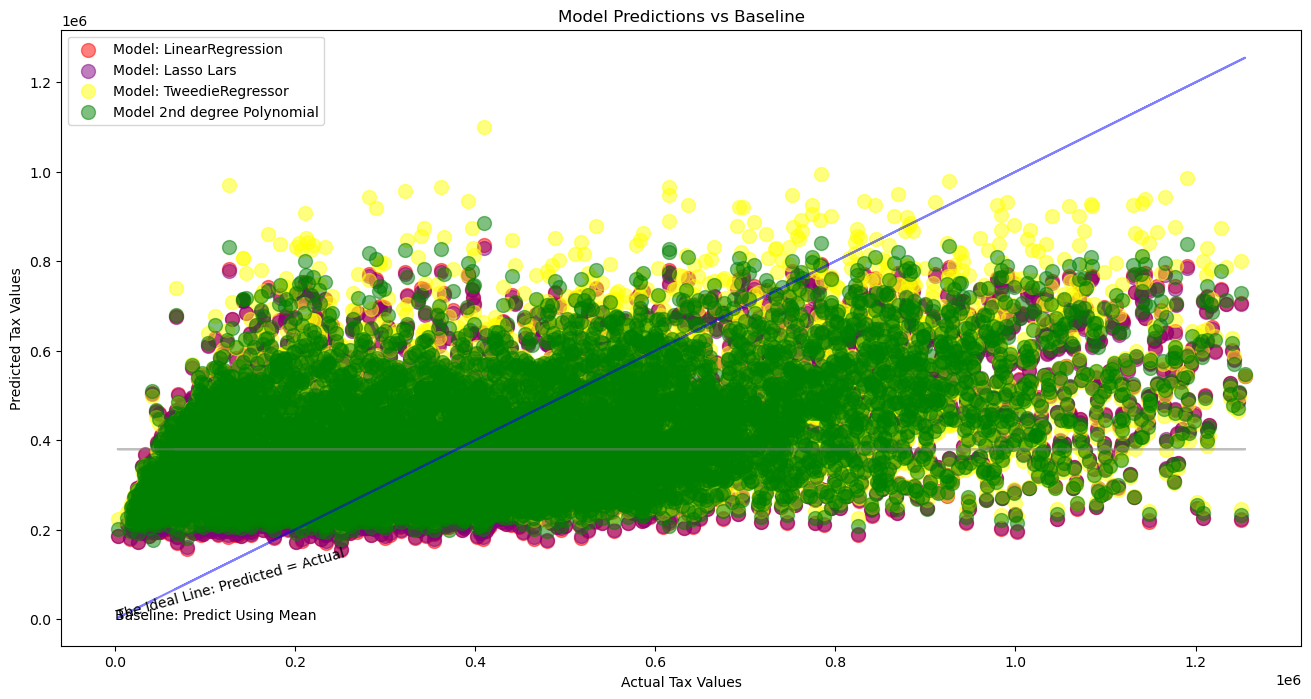

In [41]:
plt.figure(figsize=(16,8))
#actual vs mean
plt.plot(y_val.tax_value, y_val.tax_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))

#actual vs. actual
plt.plot(y_val.tax_value, y_val.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

#actual vs. LinearReg model
plt.scatter(y_val.tax_value, y_val.tax_value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
#actual vs. LassoLars model
plt.scatter(y_val.tax_value, y_val.tax_value_pred_lars, 
            alpha=.5, color="purple", s=100, label="Model: Lasso Lars")
#actual vs. Tweedie/GenLinModel
plt.scatter(y_val.tax_value, y_val.tax_value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
#actual vs. PolynomReg/Quadratic
plt.scatter(y_val.tax_value, y_val.tax_value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Values")
plt.ylabel("Predicted Tax Values")
plt.title("Model Predictions vs Baseline")
plt.show()

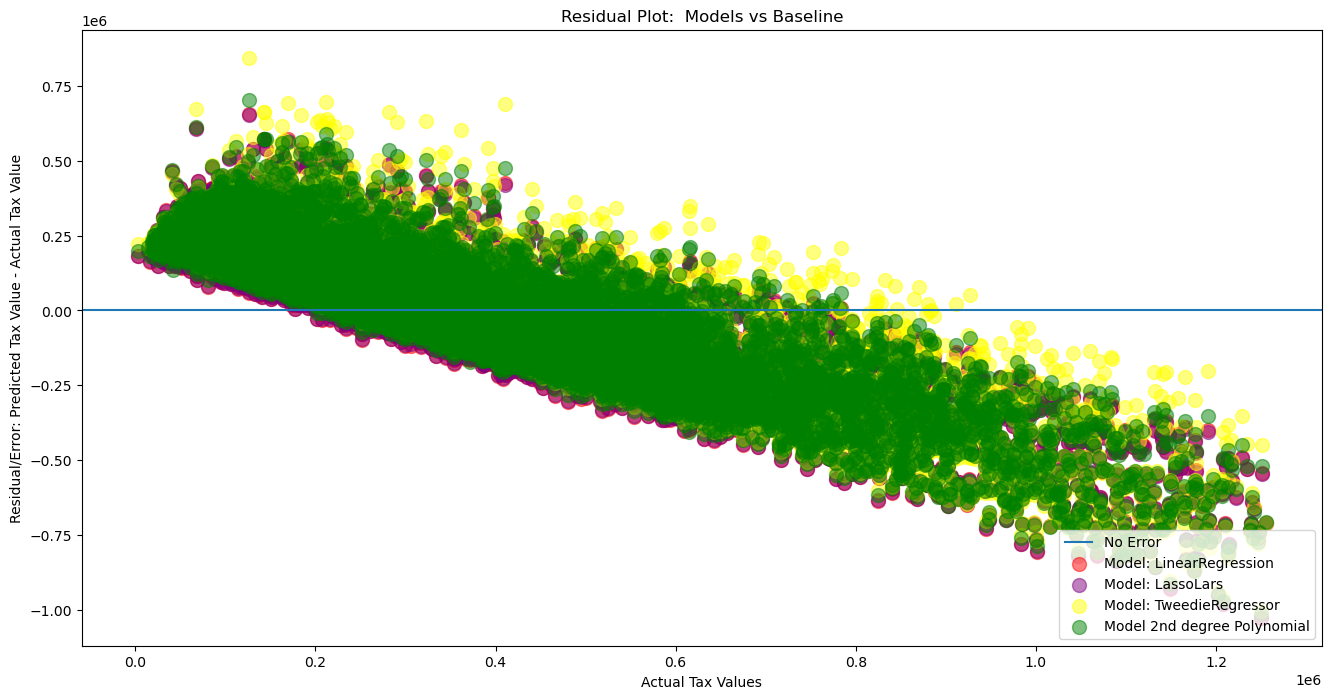

In [42]:
plt.figure(figsize=(16,8))

plt.axhline(label="No Error")


plt.scatter(y_val.tax_value, y_val.tax_value_pred_lm - y_val.tax_value, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_val.tax_value, y_val.tax_value_pred_lars - y_val.tax_value, 
             alpha=.5, color="purple", s=100, label="Model: LassoLars")
plt.scatter(y_val.tax_value, y_val.tax_value_pred_glm - y_val.tax_value, 
             alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_val.tax_value, y_val.tax_value_pred_lm2 - y_val.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")

plt.legend(loc=4)
plt.xlabel("Actual Tax Values")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
plt.title("Residual Plot:  Models vs Baseline")
plt.show()

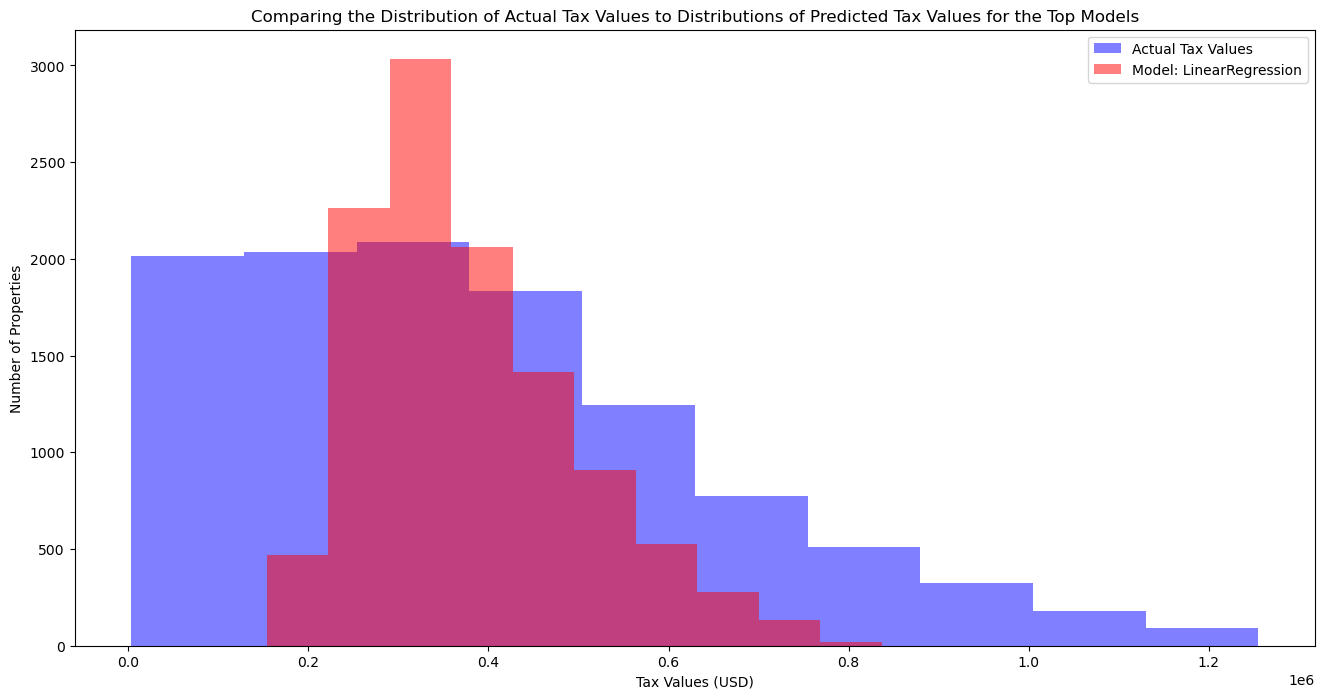

In [43]:
# plot to visualize actual vs predicted models
plt.figure(figsize=(16,8))

plt.hist(y_val.tax_value, color='blue', alpha=.5, label="Actual Tax Values")
plt.hist(y_val.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
# plt.hist(y_val.tax_value_pred_lars, color='purple', alpha=.5, label="Model: Lasso Lars")
# plt.hist(y_val.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
# plt.hist(y_val.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")

plt.xlabel("Tax Values (USD)")
plt.ylabel("Number of Properties")
plt.title("Comparing the Distribution of Actual Tax Values to Distributions of Predicted Tax Values for the Top Models")
plt.legend()
plt.show()

#### Evaluation of Models

In [44]:
metric_df

,model,RMSE_train,RMSE_validate,R2_validate
0,mean_baseline,253476.253600,258209.362308,0.000000
1,OLS_Regressor,223742.131038,226489.511794,0.230834
2,lasso_alpha5,223750.441859,226524.532972,0.230587
3,glm_gamma,224342.973499,227046.792188,0.226967
4,quadratic,223538.939336,226501.419547,0.230763


The model chosen to test is the Ordinary Least Squares using Linear Regression. This model had the highest R2 metric, which indicates that this model best explains the variation in the predicted tax values. This metric measures the strength of the relationship between the model and the target variable. This model also has the mowest RMSE (area of collective error) on the validate dataset. 

#### Testing

In [45]:
# predict on test
y_test['tax_value_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm)**(1/2)

print("RMSE for OLS Model using Linear Regression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using Linear Regression
Out-of-Sample Performance:  225904.33488277017


In [46]:
# Evaluating the GLM model against the baseline

((rmse_train_mu - rmse_test)/rmse_train_mu) * 100

10.877515477528268

### Conclusion

Overall, the model developed will enable us to predict the home values 10.88% more accurately than the baseline mean. This is accomplished by using the key drivers which we identified to be number of bathrooms and bedrooms and the squarefeet of a home. We can expect to see houses in Orange County and Colusa County to have higher values than those in Los Angeles County on average solely due to the location. We can expect to see older house generally valued less than newer builds. On unseen data, we can expect that the model will predict values higher than the actual home value, and that it will have a higher margin of error for homes valued on the lower and higher end of the spectrum for that area with a 23% explainable variance.  

### Moving Forward

Given more time, I would like to explore the following actions:

    - Incorporate the other features int he dataset to train and fit each model and see if that changes the scores and the model which is most accurate
    - Include other features in the dataset from the database such as fireplace, spa, etc., to see if any of these features contribute strongly to the home value
    - Look at the 2017 transactions as a sample compared to all the Single Family properties to see if we can determine a common feature as to why those properties sold and why the others did not
    - Analyze the properties within each county instead of all together as we have determined that 'location, location, location' does in fact matter in a home's value

### Recommendations

- One of business questions pertained to isolating possible physical features of homes located across the three counties to try and explain the difference in home value when the physcial features are the same. I'd recommend researching the communities in each of these counties to try to and find the driving factors that may be outside of the home that contribute to the higher or lower prices. 

- Fire Maggie

- Examine the existing model and see how it compares to the baseline and the OLS model